In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french/train.fr
/kaggle/input/english-turkish-v5/val.txt
/kaggle/input/english-turkish-v5/test.txt
/kaggle/input/english-turkish-v5/train.txt
/kaggle/input/multi30k-de-en/validation/val.en
/kaggle/input/multi30k-de-en/validation/val.de
/kaggle/input/multi30k-de-en/training/train.de
/kaggle/input/multi30k-de-en/training/train.en
/kaggle/input/multi30k-de-en/mmt16_task1_test/test.fr
/kaggle/input/multi30k-de-en/mmt16_task1_test/._test.fr
/kaggle/input/multi30k-de-en/mmt16_task1_test/test.de
/kaggle/input/multi30k-de-en/mmt16_task1_test/test.en
/kaggle/input/multi30k-de-en/mmt16_task1_test/._test.en
/kaggle/input/multi30k-de-en/mmt16_task1_test/._test.de
/kaggle/input/english-turkish-v6/val.txt
/kaggle/input/english-turkish-v6/test.txt
/kaggle/input/english-turkish-v6/train.txt


# Neural Machine Translation by Jointly Learning to Align and Translate

## (fr_en dataset in srticle)

This notebook to implement the paper titled by [Neural Machine Translation by Jointly Learning to Align and Translate](https://paperswithcode.com/paper/neural-machine-translation-by-jointly). This model achives a very good perplexity, better than the basic encoder-decoder model.

## Overview

As a reminder, here is a graphical illustration of the general encoder-decoder model:

![](https://raw.githubusercontent.com/parisa-khaleghi/Neural_Machine_Translation/063e9c0127d9e8608b30ef27a0fd99f15f547c40/img/seq2seq1.png)

In the previous model, the encoder encodes the whole input sentence into a single-length vector, which would lead to information loss.

The following figure illustrates the general idea of the proposed RNNsearch model in this paper:

![](https://raw.githubusercontent.com/parisa-khaleghi/Neural_Machine_Translation/063e9c0127d9e8608b30ef27a0fd99f15f547c40/img/seq2seq7.png)

This model handles the bottleneck in the basic model by using attention, i.e, at each time the decoder produces a new target word, it looks to source positions and know the important parts for the translation and this is done by the proposed alignment model.

$$w = \sum_{i}a_ih_i$$

a is the attention vector, and H is the source sentence hidden states (annotations).

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction.

## Preparing Data

using torchtext, and using spaCy to assist in the tokenization of the data.

In [2]:
# !python -m spacy download tr_core_news_sm

In [3]:
!pip install spacy==3.4.2

In [4]:
!pip install spacy-transformers==1.1.8


In [5]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.7 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done


In [6]:
!pip install https://huggingface.co/turkish-nlp-suite/tr_core_news_md/resolve/main/tr_core_news_md-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.0/156.0 MB 8.3 MB/s eta 0:00:0000:0100:01


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import spacy
import numpy as np
import random
import math
import time
from tqdm import tqdm

In [8]:
# Seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
# Tokenizers
spacy_en = spacy.load("en_core_web_sm")
spacy_tr = spacy.load("tr_core_news_md")

## Create the tokenizers.

The links below also used:
- [Multi30k De &lt;--&gt;En](https://www.kaggle.com/datasets/hemanthkumar21/multi30k-de-en) Dataset in kaggle
- [Multi30k Data Repository](https://github.com/multi30k/dataset)
- for [train.fr.gz](https://github.com/multi30k/dataset/blob/master/data/task1/raw/train.fr.gz) dataset

Note: The multi30k dataset provided by torchtext.datasets contains the training/testing/validation sets for English and German, however for French it only contains a test set - even though training and validation sets are available. [Reference](https://github.com/pytorch/text/issues/762)

In [10]:
def tokenize_en(text):
    if isinstance(text, tuple):
        text = text[0]  # Assuming the text to be tokenized is the first element of the tuple
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_tr(text):
    if isinstance(text, tuple):
        text = text[1]  # Assuming the Turkish text is the second element of the tuple
    return [tok.text for tok in spacy_tr.tokenizer(text)]

In [11]:
!pip install portalocker==2.8.2

In [12]:
# import os
# file_path = '/root/.cache/torch/text/datasets/Multi30k/training.tar.gz'
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"Deleted corrupted file: {file_path}")
# else:
#     print(f"File not found: {file_path}")

In [13]:
# Function to yield tokens from the file
def yield_tokens_en(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            yield tokenize_en(line)
            
# vocab_en = torchtext.vocab.build_vocab_from_iterator(map(tokenize_en, Multi30k(split='train')), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_en = build_vocab_from_iterator(yield_tokens_en('/kaggle/input/multi30k-de-en/training/train.en'), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [14]:
# Function to yield tokens from the file
def yield_tokens_tr(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            yield tokenize_tr(line)

vocab_tr = torchtext.vocab.build_vocab_from_iterator(yield_tokens_tr('/kaggle/input/multi30k-de-en/training/train.de'), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

## Build the vocabulary.

In [15]:
vocab_en.set_default_index(vocab_en['<unk>'])
vocab_tr.set_default_index(vocab_tr['<unk>'])

In [16]:
# Custom Dataset class
class EuroparlDataset(Dataset):
    def __init__(self, file_path, vocab_en, vocab_tr, tokenizer_en, tokenizer_tr):
        self.pairs = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    src_sentence, trg_sentence = parts
                    src_indexes = [vocab_en[token] for token in tokenizer_en(src_sentence)]
                    trg_indexes = [vocab_tr[token] for token in tokenizer_tr(trg_sentence)]
                    self.pairs.append((torch.tensor(src_indexes), torch.tensor(trg_indexes)))
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

In [17]:
# Function to create data loaders
def create_data_loader(file_path, vocab_en, vocab_tr, tokenizer_en, tokenizer_tr, batch_size):
    dataset = EuroparlDataset(file_path, vocab_en, vocab_tr, tokenizer_en, tokenizer_tr)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=generate_batch)
    return data_loader

In [18]:
# Function to collate data into batches
def generate_batch(data_batch):
    src_batch, trg_batch = [], []
    for src_item, trg_item in data_batch:
        src_batch.append(torch.cat([torch.tensor([vocab_en["<bos>"]]), src_item, torch.tensor([vocab_en["<eos>"]])], dim=0))
        trg_batch.append(torch.cat([torch.tensor([vocab_en["<bos>"]]), trg_item, torch.tensor([vocab_en["<eos>"]])], dim=0))
    src_batch = pad_sequence(src_batch, padding_value=vocab_en["<pad>"]).to(device)
    trg_batch = pad_sequence(trg_batch, padding_value=vocab_en["<pad>"]).to(device)
    return src_batch, trg_batch

## Me have made the train, validation and test set using separate file, and here we just read them.

In [19]:
# Paths to the new dataset files
train_file = '/kaggle/input/english-turkish-v6/train.txt'
val_file = '/kaggle/input/english-turkish-v6/val.txt'
test_file = '/kaggle/input/english-turkish-v6/test.txt'

In [20]:
# Create data loaders
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = create_data_loader(train_file, vocab_en, vocab_tr, tokenize_en, tokenize_tr, BATCH_SIZE)
val_loader = create_data_loader(val_file, vocab_en, vocab_tr, tokenize_en, tokenize_tr, BATCH_SIZE)
test_loader = create_data_loader(test_file, vocab_en, vocab_tr, tokenize_en, tokenize_tr, BATCH_SIZE)
print("Create data loaders was set!", BATCH_SIZE,device,train_loader,val_loader,test_loader)

# Model dimensions and padding index
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_tr)
TRG_PAD_IDX = vocab_en["<pad>"]
print("Model dimensions and padding index was set!", INPUT_DIM,OUTPUT_DIM,TRG_PAD_IDX)

Create data loaders was set! 128 cpu <torch.utils.data.dataloader.DataLoader object at 0x7d4a90ad7250> <torch.utils.data.dataloader.DataLoader object at 0x7d4a9177ada0> <torch.utils.data.dataloader.DataLoader object at 0x7d4a910109d0>
Model dimensions and padding index was set! 10838 18552 1


## Building the Seq2Seq Model

Here we have 4 parts:
1. Attention.
2. Encoder.
2. Decoder.
3. Seq2Seq model.

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

attn is a linear layer.

For each example in the batch as the attention should be over the length of the source sentence:

$$\hat{a}_t = v E_t$$

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below:

![](https://raw.githubusercontent.com/parisa-khaleghi/Neural_Machine_Translation/main/img/seq2seq9.png)

In [21]:
# Define Attention, Encoder, Decoder, and Seq2Seq classes
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*.

![](https://raw.githubusercontent.com/parisa-khaleghi/Neural_Machine_Translation/main/img/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$ 

The context vector:

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        return outputs, hidden

### Decoder

The decoder contains the attention layer, `attention`:

$$w_t = a_t H$$

The decoder hidden state:

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

To make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$:

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://raw.githubusercontent.com/parisa-khaleghi/Neural_Machine_Translation/main/img/seq2seq10.png)

In [23]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

### Seq2Seq

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## Training the Model

Also, we used Adam optimizer.

In [25]:
# Instantiate the model
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# Model training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)

# optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# Initialize weights
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

# Define a function to count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 47,220,856 trainable parameters


## Create the training loop... and the evaluation loop, 
## and finally, define a timing function.

In [26]:
!pip install --upgrade tqdm

In [27]:
# Training and evaluation functions
# def train(model, iterator, optimizer, criterion, clip):
#     model.train()
#     epoch_loss = 0
#     progress_bar = tqdm(iterator, total=len(iterator), desc='Training', leave=False)
# #     progress_bar = tqdm(train_loader, total=len(train_loader), desc='Training', leave=False)

#     for i, batch in enumerate(iterator):
#         src, trg = batch
#         optimizer.zero_grad()
#         output = model(src, trg)
#         output_dim = output.shape[-1]
#         output = output[1:].view(-1, output_dim)
#         trg = trg[1:].view(-1)
#         loss = criterion(output, trg)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
#         epoch_loss += loss.item()
#         progress_bar.set_postfix(loss=loss.item())

#     return epoch_loss / len(iterator)

import sys

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
#     progress_bar = tqdm(iterator, total=len(iterator), desc='Training', leave=False)
#     progress_bar = tqdm(iterator, total=len(iterator), desc='Training', file=sys.stdout, leave=False)

    for i, batch in enumerate(iterator):
        src, trg = batch
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        print(f"\rTraining: Batch {i+1}/{len(iterator)}, Loss: {loss.item():.4f}", end="")
        
        # Update progress bar for each batch processed
#         progress_bar.update(1)
#         progress_bar.set_postfix(loss=loss.item(), batch=f"{i+1}/{len(iterator)}")

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            output = model(src, trg, 0)  # Turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Time calculation function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Then, train the model, saving the parameters that give us the best validation loss.

In [28]:
# Training loop
train_losses = []
val_losses = []

N_EPOCHS = 5  # Number of epochs - adjust as needed
CLIP = 1       # Gradient clip threshold

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss                            
        torch.save(model.state_dict(), 'tut-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

Training: Batch 5/5, Loss: 1.6123Epoch: 01 | Time: 1m 11s
	Train Loss: 3.209 | Train PPL:  24.750
	Val. Loss: 1.483 | Val. PPL:   4.405
Training: Batch 5/5, Loss: 1.3116Epoch: 02 | Time: 1m 9s
	Train Loss: 1.436 | Train PPL:   4.206
	Val. Loss: 1.466 | Val. PPL:   4.334
Training: Batch 5/5, Loss: 1.4100Epoch: 03 | Time: 1m 4s
	Train Loss: 1.335 | Train PPL:   3.800
	Val. Loss: 1.392 | Val. PPL:   4.024
Training: Batch 5/5, Loss: 1.2890Epoch: 04 | Time: 1m 7s
	Train Loss: 1.304 | Train PPL:   3.685
	Val. Loss: 1.377 | Val. PPL:   3.963
Training: Batch 5/5, Loss: 1.3063Epoch: 05 | Time: 1m 11s
	Train Loss: 1.268 | Train PPL:   3.554
	Val. Loss: 1.354 | Val. PPL:   3.873


## Finally, test the model on the test set using these "best" parameters.

In [29]:
# Load the best model 
model.load_state_dict(torch.load('tut-model.pt'))

# Test the model   
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |') 

| Test Loss: 1.496 | Test PPL:   4.464 |


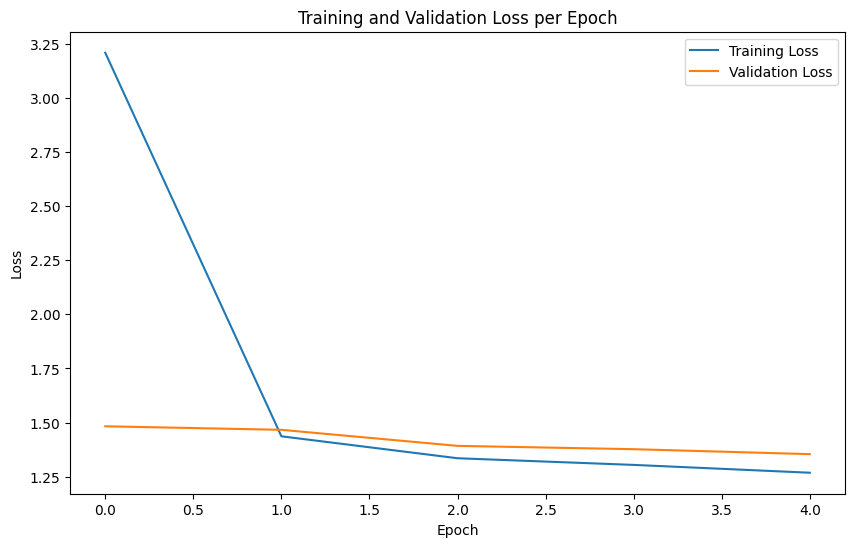

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Final Report:

We've improved on the previous model. 
For this porpose, we used kaggle notebook.
The best **loss that we achieved was 0.39**.